# Neuron Optimization

In [1]:
import numpy as np
from math import e
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(7)

In [3]:
from rsnn.new.optim import Solver
from rsnn.new.rand import rand_f_times
from rsnn.new.utils import receive_in_spikes, neurons_counts_in_sources
# from rsnn.new.sim import clean_states

In [5]:
period, f_rate = 100.0, 0.5
n_neurons, n_synapses = 500, 1_000
neurons = np.arange(n_neurons, dtype=np.int64)

# Initialize the spike trains
f_times, f_sources = rand_f_times(n_neurons, period, f_rate, rng)

f_sorter = np.lexsort((f_times, f_sources))
f_sources = np.take_along_axis(f_sources, f_sorter, axis=-1)
f_times = np.take_along_axis(f_times, f_sorter, axis=-1)
f_neurons_counts = neurons_counts_in_sources(f_sources, neurons)
# f_partition = np.cumsum(f_neurons_counts) # This is not needed for the current context but could be useful later

# Initialize random synaptic connections
in_sources = rng.integers(0, n_neurons, (n_neurons, n_synapses))
in_delays = rng.random((n_neurons, n_synapses))
in_weights = rng.random((n_neurons, n_synapses))
in_channels = np.tile(np.arange(n_synapses, dtype=np.int64), (n_neurons, 1))

in_sorter = np.lexsort((in_delays, in_sources))
in_sources = np.take_along_axis(in_sources, in_sorter, axis=-1)
in_delays = np.take_along_axis(in_delays, in_sorter, axis=-1)
in_weights = np.take_along_axis(in_weights, in_sorter, axis=-1)

in_neurons_counts = np.zeros((n_neurons, n_neurons), dtype=np.int64)
for l in range(n_neurons):
    in_neurons_counts[l] = neurons_counts_in_sources(in_sources[l], neurons)

In [6]:
f_partition = np.cumulative_sum(f_neurons_counts, include_initial=True)
# list_f_times = [f_times[f_partition[l]:f_partition[l + 1]] for l in neurons]

In [79]:
l = 42
f_times_l = f_times[f_partition[l] : f_partition[l + 1]]
in_times_l, in_synapses_l = receive_in_spikes(f_times, f_sources, f_neurons_counts, in_sources[l], in_delays[l], in_channels[l], in_neurons_counts[l])
f_times_l

array([ 0.29635579,  2.41106352,  5.37355666,  9.56885952, 12.42959034,
       15.57470692, 22.46521841, 26.39606604, 28.40770581, 37.80769236,
       40.1557245 , 43.26347092, 48.41631654, 50.63301633, 55.38547395,
       56.74945352, 63.25220516, 64.96722155, 69.16265205, 72.41389589,
       80.71737644, 81.93563355, 86.96071652, 88.55483727, 96.62923724,
       98.50722406])

In [80]:
solver = Solver(n_synapses, -e, e)

2025-07-31 22:20:41.734' - INFO - Solver initialized with 1000 synapses.


In [81]:
solver.init_objective()


2025-07-31 22:20:42.436' - INFO - Solver initialized with an objective.


In [82]:
# add template cstrs instead ???
solver.init_template_constraints(
    f_times_l, in_times_l, in_synapses_l, period
)

2025-07-31 22:20:43.642' - INFO - Solver initialized with 26 constraints.


In [83]:
assert solver.run() == 1

2025-07-31 22:20:51.213' - INFO - Learning succeeds! Solved in 6 refinement iterations. Number of variables: 1000. Number of constraints: 74. Cost: 2.542826.


In [11]:
solver.z_c0[0][0]

np.float64(-1.0)

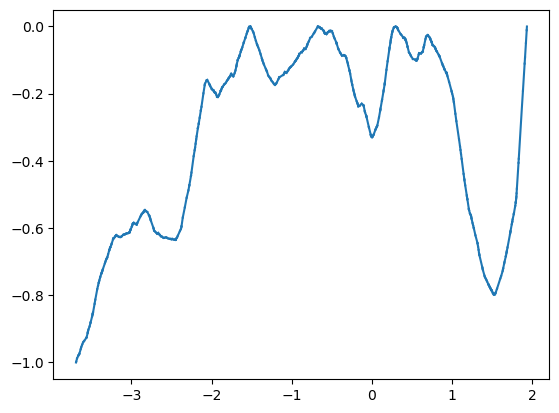

In [49]:
for n in range(len(solver.z_length[0])):
    dt = np.arange(0.0, solver.z_length[0][n], 1e-4)
    c0 = solver.z_c0[0][n]
    c1 = solver.z_c1[0][n]
    plt.plot(solver.z_start[0][n] + dt, (c0 + c1 * dt) * np.exp(-dt), c='C0')

In [ ]:
in_times = np.repeat(f_times, in_neurons_counts[0, f_sources]) + np.repeat(
        in_delays[0], f_neurons_counts[in_sources[0]]
    )


In [2]:
def count_inputs(n_sources, in_sources):
    n_neurons, n_inputs = in_sources.shape

    count_in_sources = np.empty((n_neurons, n_sources), dtype=np.int64)
    ext_in_sources = np.empty(n_inputs + n_sources, dtype=np.int64)
    ext_in_sources[-n_sources:] = np.arange(n_sources)

    for i in range(n_neurons):
        ext_in_sources[:n_inputs] = in_sources[i]
        _, count_in_sources[i] = np.unique(ext_in_sources, return_counts=True)
        count_in_sources[i] -= 1

    return count_in_sources

In [3]:
n_neurons = 1000
n_inputs = 1000
in_sources = rng.integers(0, n_neurons, (n_neurons, n_inputs))

counts_jit = count_inputs(n_neurons, in_sources)

NameError: name 'rng' is not defined

In [84]:
# can be done once at the beginning of the simulation
unique_in_sources, count_in_sources = np.unique, return_counts=True, axis=0)
count_in_sources -= 1
unique_in_sources, count_in_sources#, np.sum(count_in_sources, axis=1)

SyntaxError: unmatched ')' (3320431413.py, line 2)

In [62]:
n_neurons = 4
n_inputs = 5
in_sources = rng.integers(0, n_neurons, n_inputs)
in_delays = rng.random(n_inputs)
in_weights = rng.random(n_inputs)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
in_sources, in_delays, in_weights

(array([0, 0, 1, 2, 3]),
 array([0.26269326, 0.77728629, 0.51269481, 0.63444705, 0.78526072]),
 array([0.98939985, 0.90779362, 0.16335177, 0.441196  , 0.71114041]))

In [63]:
# can be done once at the beginning of the simulation
unique_in_sources, count_in_sources = np.unique(np.concatenate([in_sources, np.arange(n_neurons)]), return_counts=True)
count_in_sources -= 1
unique_in_sources, count_in_sources, np.sum(count_in_sources) == n_inputs

(array([0, 1, 2, 3]), array([2, 1, 1, 1]), np.True_)

In [64]:
n_spikes = 5
f_times = rng.random(n_spikes)
f_sources = rng.integers(0, n_neurons, n_spikes)
sorter = np.lexsort((f_times, f_sources))
f_sources = np.take_along_axis(f_sources, sorter, axis=0)
f_times = np.take_along_axis(f_times, sorter, axis=0)
f_times, f_sources

(array([0.0321315 , 0.47707089, 0.17531832, 0.25621281, 0.1152033 ]),
 array([0, 0, 1, 2, 3]))

In [65]:
# done for every new f_sources and f_times
unique_f_sources, count_f_sources = np.unique(np.concatenate([f_sources, np.arange(n_neurons)]), return_counts=True)
count_f_sources -= 1
unique_f_sources, count_f_sources, np.sum(count_f_sources) == n_spikes

(array([0, 1, 2, 3]), array([2, 1, 1, 1]), np.True_)

In [66]:
in_times = np.repeat(f_times, count_in_sources[f_sources]) + np.repeat(in_delays, count_f_sources[in_sources])
in_channels = np.repeat(np.arange(n_inputs), count_f_sources[in_sources])
# in_weights = np.repeat(in_weights, count_f_sources[in_sources])
in_weights[in_channels], np.repeat(in_weights, count_f_sources[in_sources])

(array([0.98939985, 0.98939985, 0.90779362, 0.90779362, 0.16335177,
        0.441196  , 0.71114041]),
 array([0.98939985, 0.98939985, 0.90779362, 0.90779362, 0.16335177,
        0.441196  , 0.71114041]))

In [ ]:
def overwrite_states_tail(start, c0, c1, new_start, new_c0, new_c1):
    n_new_states = new_start.size
    
    if not np.isnan(start[-n_new_states]):
        raise ValueError("The new states do not fit in the existing arrays.")
    
    start[-n_new_states:] = new_start
    c0[-n_new_states:] = new_c0
    c1[-n_new_states:] = new_c1

In [ ]:
# can be done once at the beginning of the simulation
_, count_in_sources = np.unique(
    np.concatenate([in_sources, np.arange(n_neurons)]), return_counts=True
)
count_in_sources -= 1

_, count_f_sources = np.unique(
    np.concatenate([f_sources, np.arange(n_neurons)]), return_counts=True
)
count_f_sources -= 1


def count_sources(n_unique_sources, sources):
    n_nodes, n_sources = sources.shape

    counts = np.empty((n_nodes, n_unique_sources), dtype=np.int64)
    ext_sources = np.empty(n_sources + n_unique_sources, dtype=np.int64)
    ext_sources[-n_unique_sources:] = np.arange(n_unique_sources)

    for i in range(n_nodes):
        ext_sources[:n_sources] = sources[i]
        _, counts[i] = np.unique(ext_sources, return_counts=True)
        counts[i] -= 1

    return counts


def receive_spikes(
    f_times,
    f_sources,
    counts_f_sources,
    in_sources,
    in_weights,
    in_delays,
    counts_in_sources,
):
    """at the neuron level"""
    in_times = np.repeat(f_times, counts_in_sources[f_sources]) + np.repeat(
        in_delays, counts_f_sources[in_sources]
    )
    in_weights = np.repeat(in_weights, counts_f_sources[in_sources])
    return in_times, in_weights


def propagate_spikes(
    f_times,
    f_sources,
    in_sources,
    in_weights,
    in_delays,
    counts_in_sources,
    start,
    ic0,
    ic1,
):
    """at the network level"""
    n_neurons, _ = in_sources.shape
    counts_f_sources = count_sources(n_neurons, f_sources[None, :])

    for l in range(n_neurons):
        in_times, in_weights = receive_spikes(
            f_times,
            f_sources,
            counts_f_sources[l],
            in_sources[l],
            in_weights[l],
            in_delays[l],
            counts_in_sources[l],
        )

        start[-in_times.size :, l] = in_times
        ic0[-in_times.size :, l] = np.zeros_like(in_weights)
        ic1[-in_times.size :, l] = in_weights

array([2., 2., 2., 3., 3.])

In [ ]:
@njit(parallel=True)
def propagate_spikes_v1(
    new_f_times,
    new_f_sources,
    in_sources,
    in_delays,
    in_weights,
    start,
    c0,
    c1,
    ic0,
    ic1,
):
    """
    Propagate new spikes through the network.
    Add new states at the end of the state arrays...

    Warning: This function assumes that the synaptic inputs are sorted by source neuron. Moreover, the states should be large enough to not overwrite existing states...

    Args:
        new_f_times (_type_): _description_
        new_f_sources (_type_): _description_
        in_sources (_type_): shape (n_neurons, n_inputs_per_neuron)
        in_delays (_type_): shape (n_neurons, n_inputs_per_neuron)
        in_weights (_type_): shape (n_neurons, n_inputs_per_neuron)
        start (_type_): _description_
        c0 (_type_): _description_
        c1 (_type_): _description_
        ic0 (_type_): _description_
        ic1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_neurons, _ = in_sources.shape
    for l in range(n_neurons):
        start_idx = np.searchsorted(in_sources[l], new_f_sources, side="left")
        end_idx = np.searchsorted(in_sources[l], new_f_sources, side="right")

        pos = -1
        for n in range(new_f_sources.shape[0]):
            num = end_idx[n] - start_idx[n]
            start[pos - num : pos, l] = (
                new_f_times[n] + in_delays[l, start_idx[n] : end_idx[n]]
            )
            # c0[pos - num : pos, l] = 0.0  # useless
            # c1[pos - num : pos, l] = 0.0  # useless
            ic0[pos - num : pos, l] = 0.0
            ic1[pos - num : pos, l] = in_weights[l, start_idx[n] : end_idx[n]]
            pos -= num

    return start, c0, c1, ic0, ic1


In [29]:
unique_f_sources, index_f_sources, count_f_sources = np.unique(f_sources, return_counts=True, return_index=True)
f_sources, unique_f_sources, index_f_sources, count_f_sources

(array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2]),
 array([0, 1, 2]),
 array([0, 3, 5]),
 array([3, 2, 5]))

In [ ]:
unique_in_sources, index_in_sources, count_in_sources = np.unique(np.concatenate([in_sources, np.arange(n_neurons)]), return_counts=True, return_index=True)
in_sources, unique_in_sources, index_in_sources, count_in_sources

(array([0, 0, 0, 2, 2]), array([0, 2]), array([0, 3]), array([3, 2]))

In [ ]:
in_times = f_times[ind1] + in_delays[ind2]
in_sources = 
in_channels = 

In [26]:
f_times, f_times[index_f_sources[1]: index_f_sources[1]+count_f_sources[1]]

(array([0.63971717, 0.74177095, 0.87133938, 0.09149561, 0.50777224,
        0.50979081, 0.54114382, 0.84715025, 0.88033215, 0.2675993 ]),
 array([0.09149561, 0.50777224, 0.50979081, 0.54114382, 0.84715025,
        0.88033215]))

In [15]:
start_idx = np.searchsorted(in_sources, f_sources, side="left")
end_idx = np.searchsorted(in_sources, f_sources, side="right")
start_idx, end_idx

(array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([5, 3, 3, 3, 0, 0, 3, 3, 3, 0]))

In [ ]:
n_neurons = 100
period, f_rate = 20.0, 0.1


f_times = rand_f_times(n_neurons, period, f_rate, rng)



In [13]:
f_times = rng.random(10)
f_sources = rng.integers(0, 3, 10)
f_times, f_sources

(array([0.87407703, 0.66221474, 0.13161582, 0.84507432, 0.94494817,
        0.90391679, 0.56971915, 0.14545995, 0.19246349, 0.92790568]),
 array([0, 1, 0, 0, 1, 2, 2, 1, 1, 1]))

In [20]:
unique_f_sources, index_f_sources, inverse_f_sources = np.unique(
    f_sources, return_index=True, return_inverse=True
)
inverse_f_sources

array([0, 1, 0, 0, 1, 2, 2, 1, 1, 1])